In [1]:
import sys
sys.path.append("../..")
import torch
import torch_geometric
import os
import os.path as osp
import numpy as np
from tqdm import tqdm as tqdm
#torch.manual_seed(1)
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.utils.checkpoint import checkpoint
from torch_cluster import knn_graph

from torch_geometric.nn import EdgeConv, NNConv
#from torch_geometric.nn.pool.edge_pool import EdgePooling

from torch_geometric.utils import normalized_cut
from torch_geometric.utils import remove_self_loops
from torch_geometric.utils.undirected import to_undirected
from torch_geometric.nn import (graclus, max_pool, max_pool_x,
                                global_mean_pool, global_max_pool,
                                global_add_pool,BatchNorm)

transform = T.Cartesian(cat=False)

def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

class DynamicReductionNetwork(nn.Module):
    # This model iteratively contracts nearest neighbour graphs 
    # until there is one output node.
    # The latent space trained to group useful features at each level
    # of aggregration.
    # This allows single quantities to be regressed from complex point counts
    # in a location and orientation invariant way.
    # One encoding layer is used to abstract away the input features.
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add',
                 norm=torch.tensor([1./500., 1./500., 1./54., 1/25., 1./1000.])):
 #                norm=torch.tensor([1., 1., 1., 1., 1.])):
        super(DynamicReductionNetwork, self).__init__()

        self.datanorm = nn.Parameter(norm,requires_grad=True)
        
        self.k = k
        start_width = 2 * hidden_dim
        middle_width = 3 * hidden_dim // 2

        
        
        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim*2),            
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.ELU(),
            nn.Dropout(0.2),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
#            nn.Dropout(0.2),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
#            nn.Dropout(0.2),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
        )
        
        
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        
        convnn3 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
                
        self.edgeconv1 = EdgeConv(nn=convnn1, aggr=aggr)
        self.edgeconv2 = EdgeConv(nn=convnn2, aggr=aggr)
        self.edgeconv3 = EdgeConv(nn=convnn3, aggr=aggr)
        
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim, hidden_dim//2),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim//2, hidden_dim//2),#added
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim//2, output_dim)
                                   )
        self.batchnorm1 = BatchNorm(hidden_dim)
        
    def forward(self, data):        
        data.x = self.datanorm * data.x
        data.x = self.inputnet(data.x)
        
        #print(data.batch)
#        data.x = self.batchnorm1(data.x)
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        data.x = self.edgeconv1(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data.edge_attr = None
        data = max_pool(cluster, data)
        
        ####
#        data.x = self.batchnorm1(data.x)
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv3.flow))
        data.x = self.edgeconv3(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data.edge_attr = None
        data = max_pool(cluster, data)
        ####
        ####
        #data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        #data.x = self.edgeconv3(data.x, data.edge_index)
        
        #weight = normalized_cut_2d(data.edge_index, data.x)
        #cluster = graclus(data.edge_index, weight, data.x.size(0))
        #data.edge_attr = None
        #data = max_pool(cluster, data)
        ####
#        data.x = self.batchnorm1(data.x)
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv2.flow))
        data.x = self.edgeconv2(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        x, batch = max_pool_x(cluster, data.x, data.batch)

        x = global_max_pool(x, batch)
#        print(self.output(x))
        return self.output(x).squeeze(-1)

In [3]:
checkpoint_dir = "/home/llr/cms/sghosh/TESTBEAM/Regression/models/testmodel2/"
checkpoint = torch.load(checkpoint_dir + "model_checkpoint_best.pth.tar")

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drn = DynamicReductionNetwork(input_dim=4,hidden_dim=20,k=10,output_dim=1,norm=torch.tensor([ 1., 1., 1., 1.]))
        
    def forward(self, data):
        logits = self.drn(data)
        #return F.softplus(logits)
        return logits


In [5]:
device = torch.device('cuda:2')#('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

Net(
  (drn): DynamicReductionNetwork(
    (inputnet): Sequential(
      (0): Linear(in_features=4, out_features=40, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=40, out_features=40, bias=True)
      (4): ELU(alpha=1.0)
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=40, out_features=20, bias=True)
      (7): ELU(alpha=1.0)
    )
    (edgeconv1): EdgeConv(nn=Sequential(
      (0): Linear(in_features=40, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=30, out_features=20, bias=True)
      (4): ELU(alpha=1.0)
    ))
    (edgeconv2): EdgeConv(nn=Sequential(
      (0): Linear(in_features=40, out_features=30, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=30, out_features=20, bias=True)
      (4): ELU(alpha=1.0)
    ))
    (edgeconv3): EdgeConv(nn=Sequential(
      (0): 

In [6]:
from ml.regression.drn.modules import DRNDataset, DRNDataModule
from ml.regression.drn.dataset_making import LayerClustersTensorMaker
from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
reader = ClueNtupleReader("v41", "cmssw", "sim_proton_v46_patchMIP")
dataset = DRNDataModule(reader, LayerClustersTensorMaker, multiprocess_loader=True, datasetFilterName="ratioSecondToFirstTrackster",
                        batch_size=2**14)

In [7]:
dataset.prepare_data()
dataset.setup("predict")
sim_loader = dataset.full_dataloader()

In [8]:
from ml.regression.drn.callbacks.simple_plots import convertListOfTensorsToNumpy, scatterPredictionVsTruth
from ml.regression.drn.callbacks.sigma_over_e import SigmaOverEPlotter
eres_plotter = SigmaOverEPlotter("full", overlaySigmaOverEResults=[reader.loadSigmaOverEResults("rechits"), reader.loadSigmaOverEResults("clue3d")])
net_outs = []
gunEnergies = []
preds = []
for batch in sim_loader:
    beamEnergy = batch.beamEnergy
    gunEnergies.append(batch.trueBeamEnergy)
    batch = batch.to("cuda:2")
    net_out = model(batch)
    net_outs.append(net_out.detach().cpu())
    preds.append((batch.tracksterEnergy/net_out.detach()).detach().cpu())
    eres_plotter.histogram_2D.fill(beamEnergy.numpy(), preds[-1])

2023-06-26 15:59:31.470116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 15:59:31.603455: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

In [9]:
net_outs = convertListOfTensorsToNumpy(net_outs)
gunEnergies = convertListOfTensorsToNumpy(gunEnergies)
preds = convertListOfTensorsToNumpy(preds)

In [10]:
len(gunEnergies)

329959

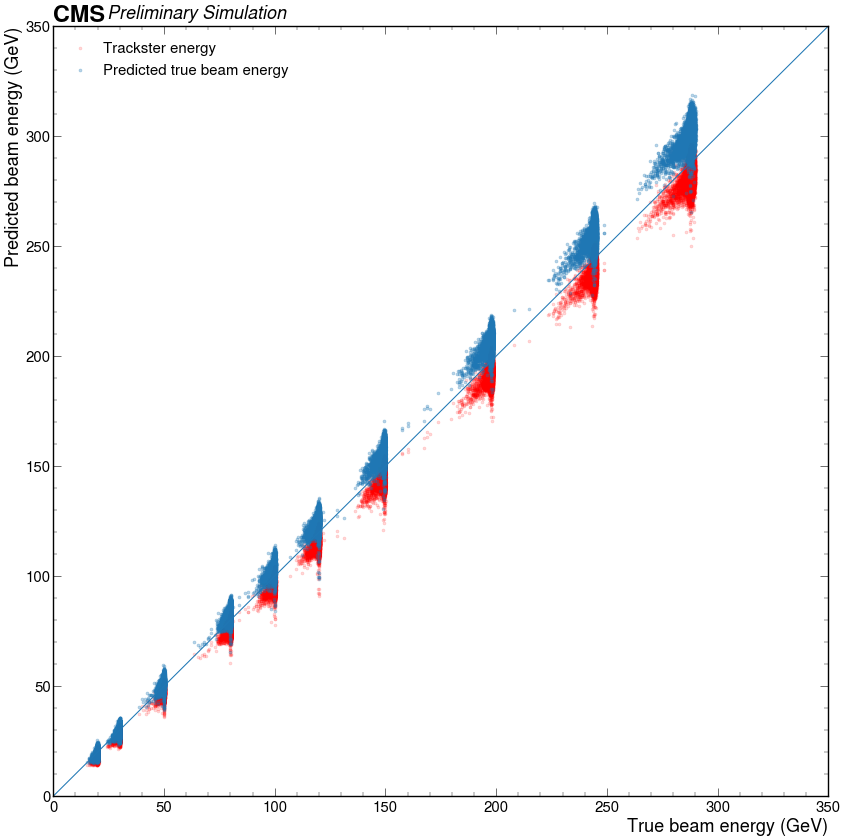

In [11]:
scatterPredictionVsTruth(gunEnergies, preds, preds*net_outs)
None

In [12]:
eres_plotter.sigma_mu_fits()
eres_plotter.fitSigmaOverE()

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/uncertainties/core.py:188: RuntimeWarning: invalid value encountered in divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],


EResolutionFitResult(S=0.22848605530083457+/-nan, C=9.628024047141336e-08+/-nan)

In [13]:
import math
from hists.parameters import synchrotronBeamEnergiesMap
from energy_resolution.sigma_over_e import sigmaOverE_fitFunction
import scipy
from uncertainties import unumpy
sigmaOverEValues = eres_plotter.sigma_mu_results
xValues = [1/math.sqrt(synchrotronBeamEnergiesMap[beamEnergy]) for beamEnergy in sigmaOverEValues.keys()]
# yValues are uncertainties float
yValues = np.array([sigmaMuResult.sigma / sigmaMuResult.mu for sigmaMuResult in sigmaOverEValues.values()])



In [14]:
def sigmaOverE_fitFunction_bis(x, S, sqrt_C):
    """ x is 1/sqrt(E), S and C are parameters """
    return (x*S)**2 + sqrt_C

In [15]:
(S, sqrt_C), covMatrix = scipy.optimize.curve_fit(sigmaOverE_fitFunction_bis, 
    xdata=xValues,
    ydata=unumpy.nominal_values(yValues**2), sigma=unumpy.std_devs(yValues**2),
    p0=[0.22, 0.6*1e-3], # starting values of parameters
    absolute_sigma=True, # units of sigma are the same as units of ydata, so this is appropriate
)
S, sqrt_C

(0.2299989397442723, -5.886295631489777e-06)

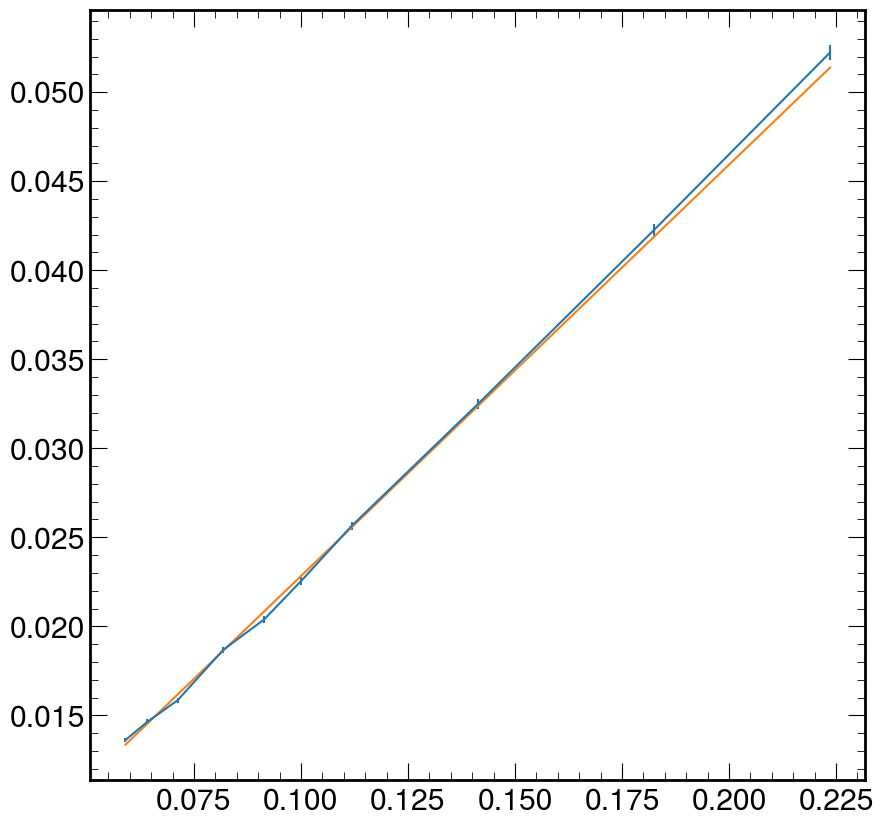

In [16]:
plt.errorbar(xValues, unumpy.nominal_values(yValues), unumpy.std_devs(yValues))
plt.plot([xValues[-1], xValues[0]], [np.sqrt(sigmaOverE_fitFunction_bis(x, S, sqrt_C)) for x in [xValues[-1], xValues[0]]])

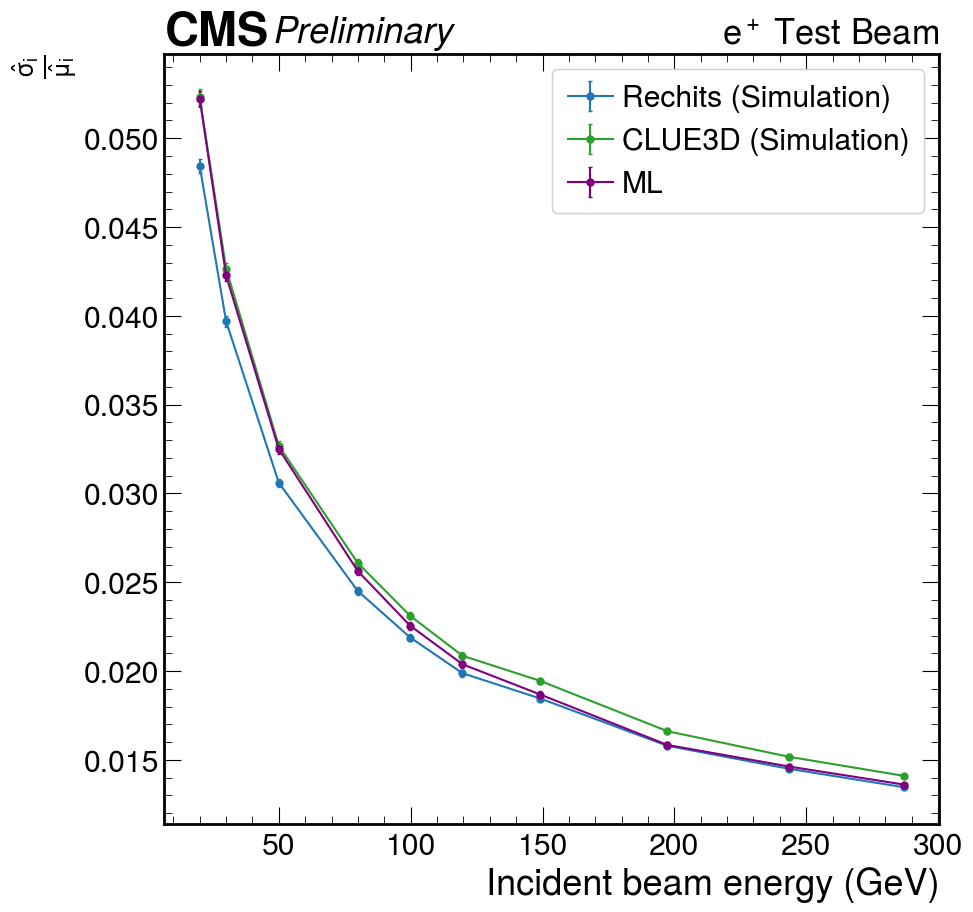

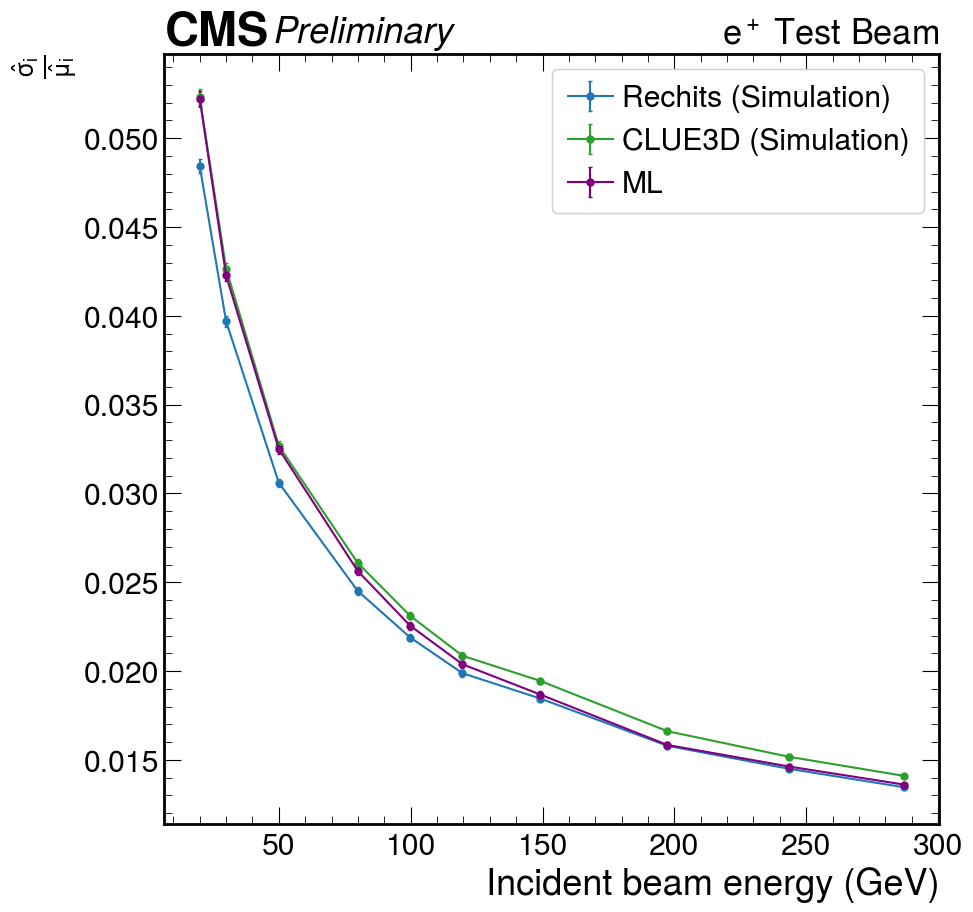

In [17]:
eres_plotter.plotSigmaOverMean(xMode="E")

LinAlgError: Array must not contain infs or NaNs

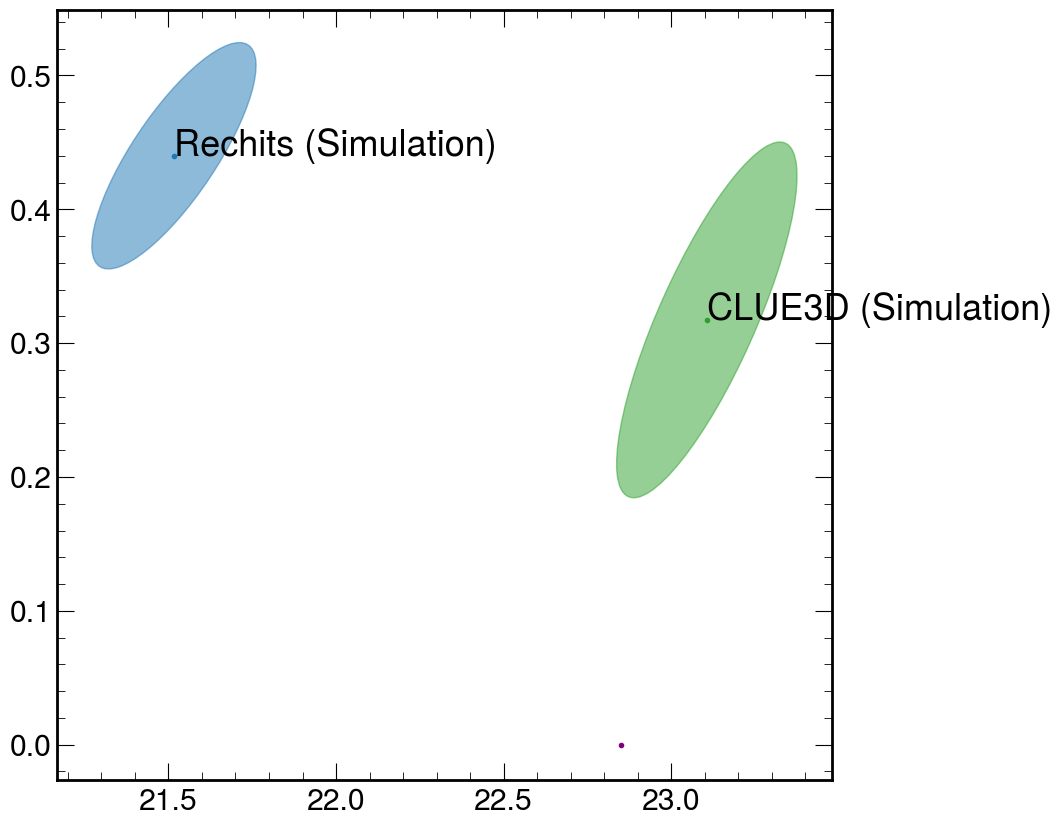

In [18]:
from energy_resolution.sigma_over_e import plotSCAsEllipse
plotSCAsEllipse(eres_plotter.overlaySigmaOverEResults + [eres_plotter.plotElt])